In [105]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline

from stan_utilities import get_model, plot_posteriors, plot_traces, get_samples

from scipy.optimize import minimize

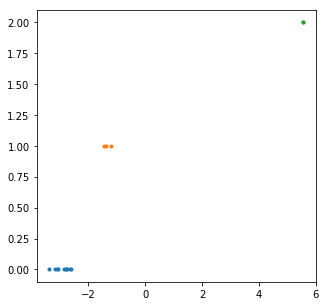

In [204]:
G = 3
groups = range(G)
N = np.array([10, 3, 2])
mu0 = 0
sigma0 = 3
sigma = 0.2

X = []
mu = []
for g in groups:
    mug = norm.rvs(loc=mu0, scale=sigma0)
    mu.append(mug)

    Xg = norm.rvs(loc=mug, scale=sigma, size=N[g])
    X.append(Xg)


plt.figure(figsize=(5, 5))
for g in groups:
    plt.plot(X[g], [g]*N[g], '.')
plt.show()

In [205]:
def log_likelihood(X, mu0, sigma02, sigma2):
    z = sigma2 / sigma02
    
    target = 0
    G = len(X)
    target += -0.5 * G * np.log(sigma02)
    for g in range(G):
        mg = np.mean(X[g])
        s2g = np.var(X[g])
        Ng = len(X[g])
        target += - 0.5 * np.log(z + Ng)
        target += - 0.5 * (Ng - 1) * np.log(sigma2)
        target += -Ng / (2 * sigma2) * (z / (z + Ng) * (mu0 - mg)**2 + s2g)
    
    return target

In [206]:
def func_to_minimize(params):
    mu0, sigma0, sigma = params
    sigma02 = sigma0**2
    sigma2 = sigma**2
    return -log_likelihood(X, mu0, sigma02, sigma2)

In [207]:
params0 = [0, 1, 1]
fit = minimize(func_to_minimize, params0)

In [208]:
fit

      fun: -4.321523015098269
 hess_inv: array([[ 4.46535450e+00, -5.56724019e-02, -3.17323900e-05],
       [-5.56724019e-02,  2.18826669e+00, -9.70409266e-05],
       [-3.17323900e-05, -9.70409266e-05,  2.10322326e-03]])
      jac: array([-1.78813934e-07, -6.55651093e-07, -6.55651093e-07])
  message: 'Optimization terminated successfully.'
     nfev: 115
      nit: 16
     njev: 23
   status: 0
  success: True
        x: array([0.42928179, 3.67638444, 0.22732928])

In [209]:
N_tot = 0
labels = []
xlist = []
for g in groups:
    N_tot += N[g]
    labels += [g+1]*N[g]
    xlist += list(X[g])
data = {
    'G': G,
    'Ntot': N_tot,
    'labels': labels,
    'x': xlist
}

In [210]:
means = [np.mean(x) for x in X]
np.mean(means)

0.43136494709855394

In [257]:
stan_file = './04-anova.stan'
pickle_file = './04-anova.pkl'
model = get_model(stan_file, pickle_file)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5e0b0e5159f75c429275ac2515fae04a NOW.


Model in model_pickle_file ./04-anova.pkl is different from model in model_code_file ./04-anova.stan.
Compiling stan model ...
Done.


In [258]:
N_tot = 0
labels = []
xlist = []
for g in groups:
    N_tot += N[g]
    labels += [g+1]*N[g]
    xlist += list(X[g])
data = {
    'G': G,
    'Ntot': N_tot,
    'labels': labels,
    'x': xlist
}

In [259]:
data

{'G': 3,
 'Ntot': 15,
 'labels': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3],
 'x': [-3.0930698131954006,
  -3.0875898947140388,
  -2.7602604245712454,
  -2.6061368001352183,
  -2.779568444529651,
  -2.862852527829209,
  -2.7800023310522604,
  -2.6492364063490745,
  -3.194079664284173,
  -3.3806999159640694,
  -1.4351004336874247,
  -1.1903619263324443,
  -1.3978529074975938,
  5.5542352256244145,
  5.554863879836753]}

In [265]:
fit = model.sampling(data=data, chains=6, iter=10_000, thin=10)

/Users/peterkomar/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [266]:
fit

Inference for Stan model: anon_model_5e0b0e5159f75c429275ac2515fae04a.
6 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=3000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0      0.29    0.07   3.61  -6.91  -1.53   0.32   2.13   7.31   2623    1.0
sigma0   6.46    0.11   5.57   2.32    3.7   5.04   7.47  18.88   2718    1.0
sigma    0.24  9.8e-4   0.05   0.16   0.21   0.24   0.27   0.38   2986    1.0
z      3.4e-3  7.5e-5 4.0e-3 1.5e-4 9.7e-4 2.2e-3 4.4e-3   0.01   2825    1.0
lp__      2.4    0.03   1.42  -1.21   1.73   2.77   3.44   4.05   2703    1.0

Samples were drawn using NUTS at Sun Dec 23 15:16:25 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

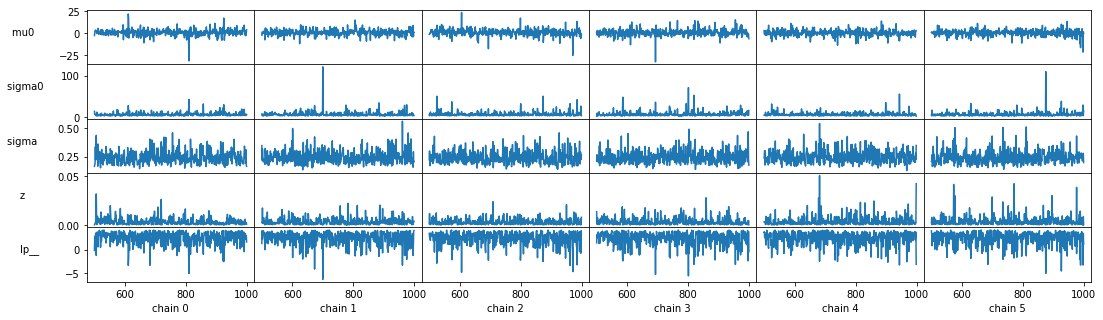

In [267]:
plot_traces(fit)

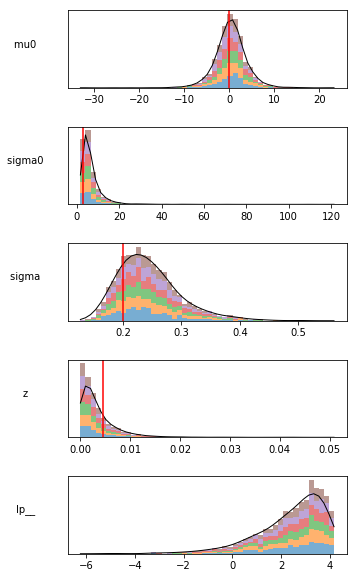

In [271]:
plot_posteriors(fit, markers={'mu0': 0, 'sigma0': 3, 'sigma':0.2, 'z':(0.2/3)**2})